In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import squints as sq

## Data Loading

In [2]:
train_o = pd.read_csv("data/train.csv")
test_o = pd.read_csv("data/test.csv")

In [66]:
def loadpred(name, d="pred/"):
    return (pd.read_csv(d+name+"-train.csv")["Predicted"],
        pd.read_csv(d+name+"-test.csv")["Predicted"])

ridge = loadpred("ridge")
forest = loadpred("forest")
ada = loadpred("adaboost")
neural1 = loadpred("torch")

import sklearn.preprocessing
pricescaler = sklearn.preprocessing.StandardScaler()
pricescaler.fit(train_o[["last_price"]])
interestscaler = sklearn.preprocessing.StandardScaler()
interestscaler.fit(train_o[["d_open_interest"]])

# def trimize(data):
#     trim = data.copy()
#     do = data["d_open_interest"]
#     trim.assign({"d_open_interest":d.where(d<4, 4).where(d>-4,-4)})

ftrainX = pd.DataFrame({
#     "last_price": pricescaler.transform(train_o[["last_price"]])[:,0],
#     "d_open_interest":trimize(interestscaler.transform(train_o[["d_open_interest"]])[:,0]),
#     "transacted_qty":np.log1p(train_o["transacted_qty"]),
    "ridge":ridge[0],
    "forest":forest[0],
    "ada":ada[0],
    "torch":neural1[0],
})
ftrainY = train_o["y"]
testX = pd.DataFrame({
#     "last_price": pricescaler.transform(test_o[["last_price"]])[:,0],
#     "d_open_interest":trimize(interestscaler.transform(test_o[["d_open_interest"]])[:,0]),
#     "transacted_qty":np.log1p(test_o["transacted_qty"]),
    "ridge":ridge[1],
    "forest":forest[1],
    "ada":ada[1],
    "torch":neural1[1],
})

In [33]:
import sklearn.model_selection
trainX, valX, trainY, valY = sklearn.model_selection.train_test_split(ftrainX, train_o["y"])

In [34]:
class StockDataset(Dataset):
    def __init__(self, x, y):
        self.X = torch.tensor(x.values.astype(np.float32), dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):       
        return (self.X[idx],
                self.y[idx]
               )

In [35]:
bsize = 64

train = DataLoader(StockDataset(trainX, trainY), batch_size=bsize, shuffle=True)
val = DataLoader(StockDataset(valX, valY), batch_size=bsize, shuffle=True)
ftrain = DataLoader(StockDataset(ftrainX, ftrainY), batch_size=bsize)

## Train

In [7]:
def mfit(model, train, val=None, lr=1e-3, nepochs=10):
    #model.cuda()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    s_train = np.zeros(nepochs)
    s_val = np.zeros(nepochs)
    for epoch in range(nepochs):
        model.train()
        for i, (data, target) in enumerate(train):
            #data, target = data.cuda(), target.cuda()
            if (i % int(len(train)/20) == 0):
                print(f"{int(i/len(train)*20)} ", end="")
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

        if (val is not None):
            s_val[epoch] = meval(model, val)
        s_train[epoch] = meval(model, train)
        print(s_train[epoch], s_val[epoch])
    return s_train, s_val

import sklearn.metrics
def meval(model, data, nsamp=8):
    model.eval()
    bsize = data.batch_size
    outs = torch.zeros(nsamp*bsize)
    targets = torch.zeros(nsamp*bsize)
    sm = nn.Softmax(dim=1)
    for i, (data, target) in enumerate(data):
        if (i >= nsamp):
            break
        outs[i*bsize:(i+1)*bsize] = sm(model(data).detach())[:,1]
        targets[i*bsize:(i+1)*bsize] = target
    return sklearn.metrics.roc_auc_score(targets, outs)

In [36]:
layers = [
    nn.Linear(4, 4),
    nn.Sigmoid(),
    nn.Dropout(p=0.1),
    nn.Linear(4, 4),
    nn.Sigmoid(),
    nn.Dropout(p=0.1),
    nn.Linear(4,2)
]

In [37]:
model = nn.Sequential(*layers)
strain, sval = mfit(model, train, val, nepochs=5, lr=1e-5)

0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.6987684932639061 0.7166796841100408
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.6189763880846684 0.7043193399660276
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.6547853950586053 0.6616335991700707
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.7316508047237033 0.6714667729665986
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.6934173986050116 0.6654791887592789


## Predict

In [38]:
ttrain = torch.tensor(ftrainX.values.astype(np.float32))
ttest = torch.tensor(testX.values.astype(np.float32))

In [39]:
fmodel = nn.Sequential(*layers)
fstrain, fsval = mfit(fmodel, ftrain, nepochs=4, lr=5e-5)

0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.6848633115874495 0.0
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.6846458527493011 0.0
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.6843817955886922 0.0
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.6843118981050015 0.0


In [40]:
def toprob(p):
    sm = nn.Softmax(dim=1)
    return sm(p.detach())[:,1]

fptrain = toprob(model(ttrain))
fptest = toprob(model(ttest))

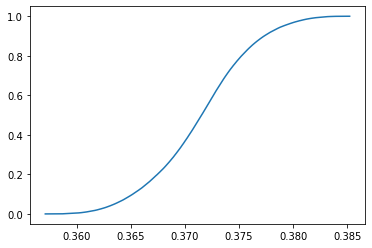

In [41]:
sq.ecdf(fptest)

In [42]:
sq.write(train_o["id"], fptrain, "blend-train.csv")
sq.write(test_o["id"], fptest, "blend-test.csv")

In [ ]:
avg = ridge[1]+forest[1]+ada[1]+neural1[1]
avgtrain = ridge[0]+forest[0]+ada[0]+neural1[0]
sklearn.metrics.roc_auc_score(train_o["y"], avgtrain)

In [ ]:
sq.write(test_o["id"], (avg-np.min(avg))/(np.max(avg)-np.min(avg)), "avg-test.csv")